In [4]:
import os

import tensorflow as tf
from tensorflow.keras.models import Model
from metrics import WeightedWeatherPenalty
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

# Parametry obrazu
img_size = (224, 224)  # zmien na odpowiednie jak przy trenowaniu
base_path = 'raw_cloud_dataset/test'
classes = ['clear','rainy','cloudy']

# Ładujemy model
model = load_model('best_model.keras', custom_objects={
                   'WeightedWeatherPenalty': WeightedWeatherPenalty})

# Przygotuj folder na wyniki
output_dir = 'gradcam_results'
os.makedirs(output_dir, exist_ok=True)

# Funkcja Grad-CAM
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model([
        model.inputs], [
        model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    print("DEBUG grads:", grads)
    if grads is None:
        print("Błąd: Grads są None!")

    grads = tf.cast(grads, tf.float32)
    last_conv_layer_output = tf.cast(last_conv_layer_output, tf.float32)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-10)
    print("Max heatmap value:", tf.reduce_max(heatmap).numpy())
    return heatmap.numpy()

# Losujemy obrazy
selected_images = []
for class_name in classes:
    class_dir = os.path.join(base_path, class_name)
    images = os.listdir(class_dir)
    selected = random.sample(images, 1)
    for img_name in selected:
        selected_images.append((class_name, os.path.join(class_dir, img_name)))

# Grad-CAM dla 9 obrazów
counters = {class_name: 1 for class_name in classes}

for class_name, img_path in selected_images:
    # Wczytaj obraz
    img = load_img(img_path, target_size=img_size)
    if img is None:
        print(f"Nie udało się wczytać obrazu: {img_path}")
        continue

    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    print(img_array.shape)
    preds = model.predict(img_array)
    print(img_array.dtype)
    predicted_class = np.argmax(preds[0])

    last_conv_layer_name = "conv2d_5"

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # konwertuj obraz na OpenCV format
    img = img_to_array(load_img(img_path, target_size=img_size))
    img = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2BGR)

    if heatmap is None:
        print(f"Heatmap dla obrazu {img_path} nie została wygenerowana.")
        continue

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    out_filename = f"{class_name}_{counters[class_name]}.png"
    out_path = os.path.join(output_dir, out_filename)

    cv2.imwrite(out_path, superimposed_img)
    print(f"Zapisano: {out_path}")

    counters[class_name] += 1

print("Gotowe!")

(1, 224, 224, 3)
1/1 [==============================] - 1s 1s/step
float32
DEBUG grads: tf.Tensor(
[[[[ 0.00e+00  0.00e+00  3.28e-06 ...  0.00e+00 -0.00e+00  0.00e+00]
   [ 0.00e+00  0.00e+00  0.00e+00 ...  0.00e+00  0.00e+00  0.00e+00]
   [ 0.00e+00  0.00e+00 -0.00e+00 ...  0.00e+00 -0.00e+00  0.00e+00]
   ...
   [ 0.00e+00  0.00e+00  0.00e+00 ...  0.00e+00  0.00e+00  0.00e+00]
   [ 0.00e+00  0.00e+00  0.00e+00 ... -0.00e+00 -0.00e+00  0.00e+00]
   [ 0.00e+00  0.00e+00 -3.46e-06 ...  0.00e+00  0.00e+00  0.00e+00]]

  [[ 0.00e+00  0.00e+00  0.00e+00 ...  0.00e+00  0.00e+00  0.00e+00]
   [-3.76e-06  7.39e-06  0.00e+00 ...  0.00e+00  0.00e+00 -1.01e-06]
   [ 0.00e+00  0.00e+00  0.00e+00 ...  0.00e+00  0.00e+00  3.64e-06]
   ...
   [ 6.26e-06  0.00e+00  0.00e+00 ...  0.00e+00  0.00e+00  3.81e-06]
   [-1.79e-07  2.09e-06  0.00e+00 ...  0.00e+00  0.00e+00  4.35e-06]
   [ 0.00e+00  0.00e+00  0.00e+00 ...  0.00e+00  0.00e+00  0.00e+00]]

  [[ 0.00e+00  0.00e+00 -0.00e+00 ...  0.00e+00 -0.00e+

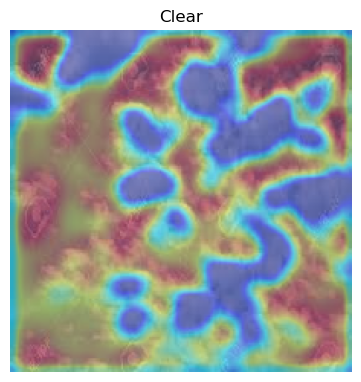

In [5]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Ścieżki do plików
paths = [
    os.path.join("gradcam_results", "clear_1.png"),
    os.path.join("gradcam_results", "cloudy_1.png"),
    os.path.join("gradcam_results", "rainy_1.png")
]

# Wczytaj obrazy
images = [Image.open(path) for path in paths]

# Wyświetl obrazy
plt.figure(figsize=(15, 5))

titles = ["Clear", "Cloudy", "Rainy"]

for i, img in enumerate(images):
    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.title(titles[i])
    plt.axis('off')

plt.show()

In [7]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from metrics import WeightedWeatherPenalty

# Parametry
test_dir = 'raw_cloud_dataset/test'
img_size = (224, 224)
batch_size = 32

# Ładowanie modelu
model = load_model('best_model.keras', custom_objects={'WeightedWeatherPenalty': WeightedWeatherPenalty})

# Funkcja do tworzenia generatora testowego z wybraną augmentacją
def create_augmented_test_generator(directory, augmentation_params, target_size=(224, 224), batch_size=32, class_mode="categorical"):
    datagen = ImageDataGenerator(rescale=1./255, **augmentation_params)

    generator = datagen.flow_from_directory(
        directory,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode,
        shuffle=False
    )
    return generator

# Typy augmentacji do testu
augmentation_types = {
    "no_augmentation": {},
    "rotation": {"rotation_range": 30},
    "horizontal_flip": {"horizontal_flip": True},
    "zoom": {"zoom_range": 0.2},
    "contrast": {"brightness_range": [0.7, 1.3]},
}

results = []

# Testowanie każdej augmentacji
for name, params in augmentation_types.items():
    print(f"\nTestujemy augmentację: {name}")

    test_gen = create_augmented_test_generator(
        directory=test_dir,
        augmentation_params=params,
        target_size=img_size,
        batch_size=batch_size
    )

    metrics = model.evaluate(test_gen, verbose=1)
    results.append((name, metrics))

# Podsumowanie wyników
print("\nPodsumowanie wyników:")
for name, metrics in results:
    print(f"{name}: {metrics}")

# Jeśli chcesz, można dodatkowo zapisać wyniki do pliku .csv
import pandas as pd
columns = ["Loss", "Accuracy", "WeightedWeatherPenalty", "Precision", "Recall", "AUC"]
df = pd.DataFrame(
    [r[1] for r in results],
    index=[r[0] for r in results],
    columns=columns
)
df.to_csv("augmentation_results.csv")
print("\nZapisano wyniki do augmentation_results.csv!")


Testujemy augmentację: no_augmentation
Found 111 images belonging to 3 classes.
4/4 [==============================] - 15s 3s/step - loss: 0.9708 - accuracy: 0.8108 - weighted_weather_penalty: 1.1622 - precision: 0.8235 - recall: 0.7568 - auc: 0.9273 

Testujemy augmentację: rotation
Found 111 images belonging to 3 classes.
4/4 [==============================] - 14s 3s/step - loss: 0.9581 - accuracy: 0.7928 - weighted_weather_penalty: 1.3423 - precision: 0.8155 - recall: 0.7568 - auc: 0.9300 

Testujemy augmentację: horizontal_flip
Found 111 images belonging to 3 classes.
4/4 [==============================] - 13s 3s/step - loss: 0.9726 - accuracy: 0.8018 - weighted_weather_penalty: 1.1712 - precision: 0.8218 - recall: 0.7477 - auc: 0.9263 

Testujemy augmentację: zoom
Found 111 images belonging to 3 classes.
4/4 [==============================] - 14s 3s/step - loss: 0.9589 - accuracy: 0.8018 - weighted_weather_penalty: 1.2523 - precision: 0.8333 - recall: 0.7658 - auc: 0.9311 

Testu

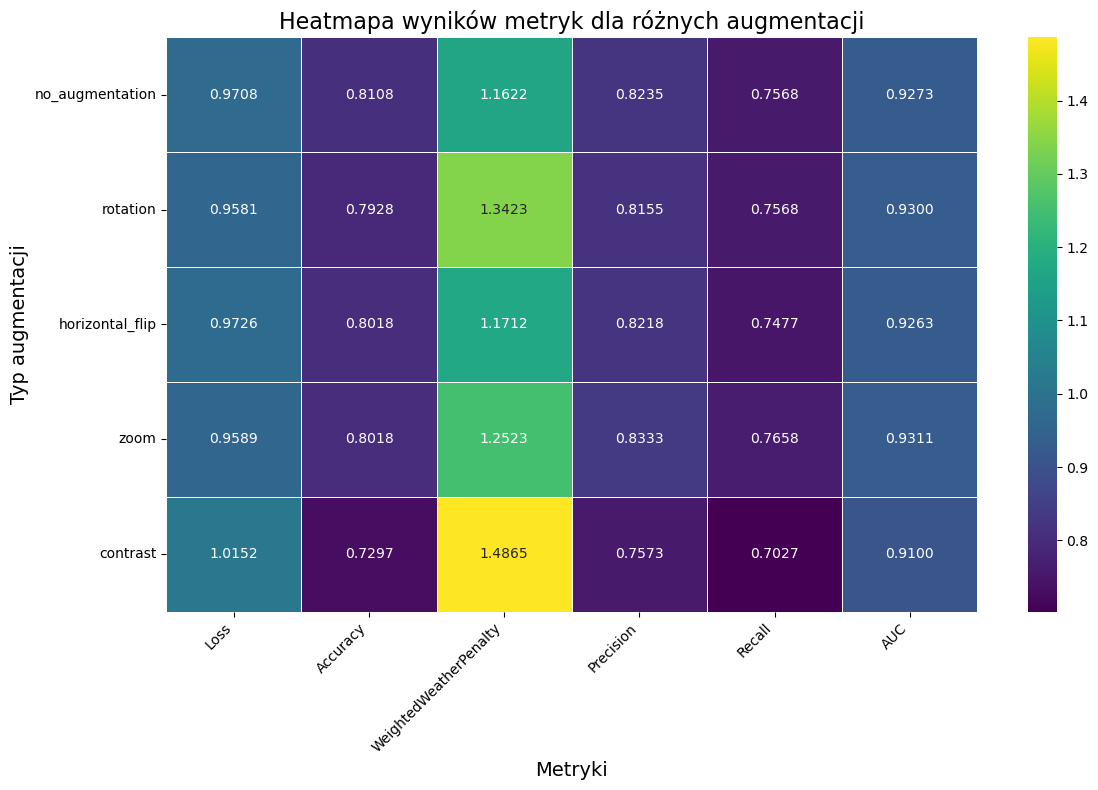

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Wczytaj wyniki
results_df = pd.read_csv('augmentation_results.csv', index_col=0)

# Ustawienia wykresu
plt.figure(figsize=(12, 8))
sns.heatmap(results_df, annot=True, fmt=".4f", cmap="viridis", cbar=True, linewidths=0.5)

plt.title('Heatmapa wyników metryk dla różnych augmentacji', fontsize=16)
plt.xlabel('Metryki', fontsize=14)
plt.ylabel('Typ augmentacji', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Zapisz wykres do pliku
plt.savefig('augmentation_results_heatmap.png')

plt.show()